In [1]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np  # adicione se precisar no 02

# Muda o diretório de trabalho para a raiz do projeto (sobe um nível de notebooks/)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(project_root)

# Adiciona a raiz ao path (por segurança)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Imports corretos (com prefixo src.)
from src.forecasting import (
    load_and_prepare_data,
    create_features,
    train_and_predict
)
from src.inventory_policies import eoq, reorder_point
from src.simulation import simulate_inventory

%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

## 2. Parâmetros da Simulação

In [2]:
# Loja para análise (mesma do notebook anterior)
STORE_ID = 1

# Horizonte de simulação (dias)
SIMULATION_DAYS = 180

# Custos (ajuste conforme o cenário real)
HOLDING_COST_PER_UNIT_PER_DAY = 0.0005  # ex.: 0.05% do valor do item por dia
SHORTAGE_COST_PER_UNIT = 100            # penalidade alta por falta
ORDER_COST = 200                        # custo fixo por pedido
LEAD_TIME_DAYS = 7                      # tempo de entrega

# Service level para safety stock (95% → z=1.65)
SERVICE_LEVEL_Z = 1.65

## 3. Obtenção da Previsão de Demanda Futura

Demanda média simulada: 4043
Desvio padrão: 436


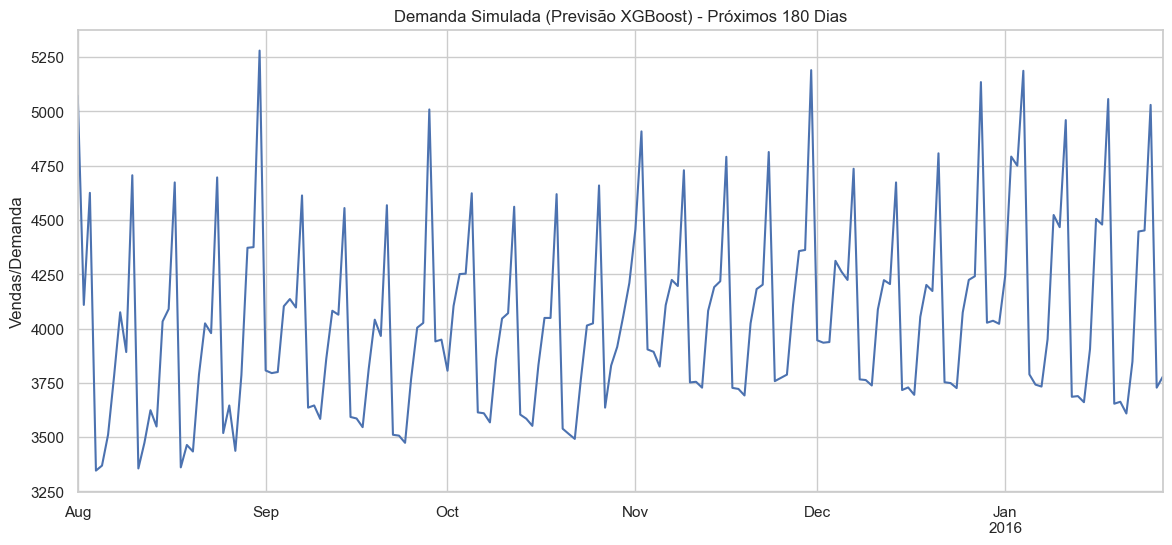

In [3]:
# Retrain o modelo e obtém previsão de teste + futura
model, _, _, _, mae = train_and_predict(store_id=STORE_ID, test_days=60)

# Dados completos com features para previsão futura
df_full = load_and_prepare_data(store_id=STORE_ID, data_path='data/')
df_feat = create_features(df_full)

# Função para prever futuro (reutilizada/adaptada do notebook anterior)
def predict_future(model, last_df, periods=SIMULATION_DAYS):
    last_date = last_df.index.max()
    future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=periods)
    
    full_df = pd.concat([last_df, pd.DataFrame({'Sales': [0]*periods}, index=future_dates)])
    full_df = create_features(full_df)
    
    future_features = full_df.tail(periods).drop('Sales', axis=1)
    future_pred = model.predict(future_features)
    
    return future_dates, future_pred

future_dates, demand_series = predict_future(model, df_feat, periods=SIMULATION_DAYS)

# Converte para Series com index de datas
demand_series = pd.Series(demand_series, index=future_dates)
demand_series = demand_series.round(0).astype(int)  # vendas inteiras

print(f"Demanda média simulada: {demand_series.mean():.0f}")
print(f"Desvio padrão: {demand_series.std():.0f}")

# Plot da demanda simulada
demand_series.plot(title=f'Demanda Simulada (Previsão XGBoost) - Próximos {SIMULATION_DAYS} Dias')
plt.ylabel('Vendas/Demanda')
plt.show()

## 4. Cálculo das Políticas Clássicas

In [4]:
# Estatísticas da demanda
demand_mean = demand_series.mean()
demand_std = demand_series.std()
annual_demand = demand_mean * 365

# EOQ
Q_eoq = eoq(demand_rate=annual_demand, 
            setup_cost=ORDER_COST, 
            holding_cost=HOLDING_COST_PER_UNIT_PER_DAY * 365)

# Ponto de reposição com safety stock
s_reorder = reorder_point(demand_mean=demand_mean,
                          demand_std=demand_std,
                          lead_time=LEAD_TIME_DAYS,
                          service_level_z=SERVICE_LEVEL_Z)

print(f"Quantidade ótima de pedido (EOQ): {Q_eoq:.0f}")
print(f"Ponto de reposição (s): {s_reorder:.0f} (inclui safety stock)")

Quantidade ótima de pedido (EOQ): 56874
Ponto de reposição (s): 30206 (inclui safety stock)


## 5. Simulação de Diferentes Políticas

In [5]:
# Definições básicas para as políticas
monthly_quantity = demand_mean * 30  # quantidade para cobrir 30 dias (baseline mensal)

# Política 1: EOQ + reorder point (usando a função modularizada)
costs_eoq, stock_levels_eoq = simulate_inventory(
    demand_series=demand_series,
    order_quantity=Q_eoq,
    reorder_point=s_reorder,
    lead_time=LEAD_TIME_DAYS,
    initial_stock=Q_eoq + s_reorder,  # estoque inicial = pedido + safety stock
    holding_cost_per_unit=HOLDING_COST_PER_UNIT_PER_DAY,
    shortage_cost_per_unit=SHORTAGE_COST_PER_UNIT,
    order_cost=ORDER_COST
)

# Política 2: Pedido fixo a cada 30 dias (baseline realista - simulação manual)
initial_stock_monthly = monthly_quantity + demand_mean * LEAD_TIME_DAYS  # inicial com buffer
stock = initial_stock_monthly
total_holding = 0
total_shortage = 0
total_orders = 0
stock_levels_monthly = [initial_stock_monthly]
day_count = 0

for demand in demand_series:
    day_count += 1
    stock -= demand
    
    if stock < 0:
        total_shortage += abs(stock)
        stock = 0
    
    total_holding += stock
    
    # Pedido fixo exatamente a cada 30 dias
    if day_count % 30 == 0:
        stock += monthly_quantity
        total_orders += 1
    
    stock_levels_monthly.append(stock)

costs_monthly = {
    'total_cost': (total_holding * HOLDING_COST_PER_UNIT_PER_DAY +
                   total_shortage * SHORTAGE_COST_PER_UNIT +
                   total_orders * ORDER_COST),
    'avg_holding': total_holding / len(demand_series),
    'total_shortage': total_shortage,
    'total_orders': total_orders
}
stock_levels_monthly = stock_levels_monthly[1:]  # alinha com o tamanho da demanda

# DataFrame comparativo
comparison = pd.DataFrame({
    'Política': ['EOQ + Reorder Point', 'Pedido Mensal Fixo'],
    'Custo Total': [costs_eoq['total_cost'], costs_monthly['total_cost']],
    'Custo Holding Médio/Dia': [costs_eoq['avg_holding'] * HOLDING_COST_PER_UNIT_PER_DAY, costs_monthly['avg_holding'] * HOLDING_COST_PER_UNIT_PER_DAY],
    'Custo Shortage Total': [costs_eoq['total_shortage'] * SHORTAGE_COST_PER_UNIT, costs_monthly['total_shortage'] * SHORTAGE_COST_PER_UNIT],
    'Número de Pedidos': [costs_eoq['total_orders'], costs_monthly['total_orders']]
})

print("Comparação de Custos")
display(comparison)

Comparação de Custos


,Política,Custo Total,Custo Holding Médio/Dia,Custo Shortage Total,Número de Pedidos
0,EOQ + Reorder Point,7312.204584,27.290025,0,12
1,Pedido Mensal Fixo,9457.267500,45.873708,0,6


## 6. Visualização dos Níveis de Estoque

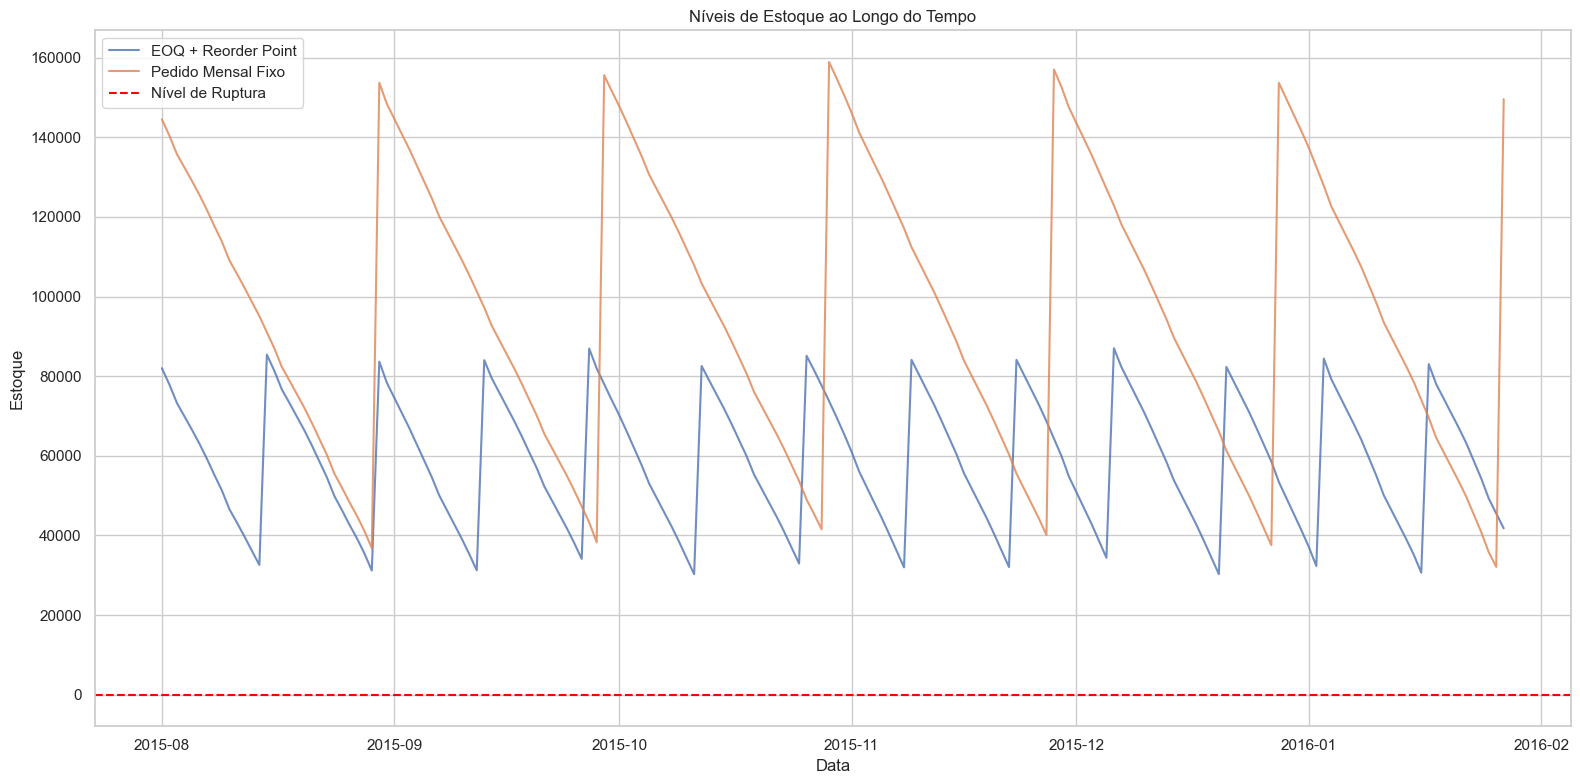

In [6]:
# Plot níveis de estoque
plt.figure(figsize=(16, 8))
plt.plot(future_dates, stock_levels_eoq, label='EOQ + Reorder Point', alpha=0.8)
plt.plot(future_dates, stock_levels_monthly, label='Pedido Mensal Fixo', alpha=0.8)
plt.axhline(0, color='red', linestyle='--', label='Nível de Ruptura')
plt.title('Níveis de Estoque ao Longo do Tempo')
plt.ylabel('Estoque')
plt.xlabel('Data')
plt.legend()
plt.tight_layout()
plt.savefig('gráfico.png')
plt.show()